# Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

**Credit card / Prepaid card**

**Bank account services**

**Theft/Dispute reporting**

**Mortgages/loans**

**Others**

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

# Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1. Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

# Step 1: Data Loading

In [1]:
from google.colab import drive
def mount_drive():
  drive.mount('/content/gdrive')
mount_drive()

Mounted at /content/gdrive


In [2]:
# Importing necessay libraries
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix




In [3]:
file = "/content/gdrive/MyDrive/sample_data_to_delete/complaints-2021-05-14_08_16.json"

In [4]:
with open(file, 'r') as f:
    data = json.load(f)

In [5]:
# Extract the _source part of each entry
complaints = [entry['_source'] for entry in data]

In [6]:
# Convert to pandas DataFrame
df = pd.DataFrame(complaints)

In [7]:
# Show basic info
print(df.shape)
print(df.columns)

(78313, 18)
Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')


In [8]:
# Show dataframe
df.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
# resulting out some of the important columns that will help to infer better
df[['product', 'sub_product', 'issue', 'sub_issue', 'complaint_what_happened']].head()

,product,sub_product,issue,sub_issue,complaint_what_happened
0,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,
1,Debt collection,Credit card debt,Written notification about debt,Didn't receive enough information to verify debt,Good morning my name is XXXX XXXX and I apprec...
2,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Problem with rewards from credit card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Mortgage,Conventional home mortgage,Trouble during payment process,None,
4,Credit card or prepaid card,General-purpose credit card or charge card,Fees or interest,Charged too much interest,


# Step 2: Text Preprocessing

We will be performing:
1.  Select only non-empty complaint texts (complaint_what_happened)
2.  Lowercase all text
3.  Remove punctuation and numbers
4.  Remove stop words
5.  Apply lemmatization

In [10]:
# Download necessary resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [11]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [12]:
# Function to clean text
def preprocess_text(text):
    # Remove line breaks and lowercase
    text = text.replace('\n', ' ').lower()
    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

In [13]:
# Function to generate POS tags
def get_pos_tags(text):
    tokens = word_tokenize(text)
    return pos_tag(tokens)

In [14]:
# Drop rows with empty complaint text
df = df[df['complaint_what_happened'].str.strip() != '']

In [15]:
# Apply text preprocessing
df['clean_text'] = df['complaint_what_happened'].apply(preprocess_text)

In [16]:
# Apply POS tagging on cleaned text
df['pos_tags'] = df['clean_text'].apply(get_pos_tags)

In [17]:
# Preview cleaned text
df[['complaint_what_happened', 'clean_text', 'pos_tags']].head()

,complaint_what_happened,clean_text,pos_tags
1,Good morning my name is XXXX XXXX and I apprec...,good morning xxxx xxxx appreciate help stop ch...,"[(good, JJ), (morning, NN), (xxxx, NN), (xxxx,..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card xxxx told agent did up...,"[(upgraded, JJ), (xxxx, NN), (xxxx, NNP), (car..."
10,Chase Card was reported on XX/XX/2019. However...,chase card reported xxxx fraudulent applicatio...,"[(chase, NN), (card, NN), (reported, VBD), (xx..."
11,"On XX/XX/2018, while trying to book a XXXX XX...",xxxx trying book xxxx xxxx ticket came offer a...,"[(xxxx, VB), (trying, VBG), (book, NN), (xxxx,..."
14,my grand son give me check for {$1600.00} i de...,grand son check deposit chase account fund cle...,"[(grand, JJ), (son, NN), (check, VB), (deposit..."


# Step 3: Exploratory Data Analysis (EDA)

This step gives us insights into the text data distribution and structure.

Key EDA Activities we will perform:

1.   Text length distribution
2.   Top frequent words
3.   Word cloud visualization
4.   Class distribution (if labels exist or for future use)


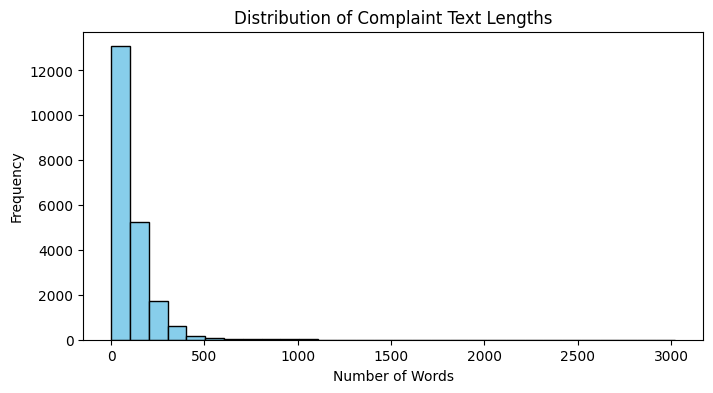

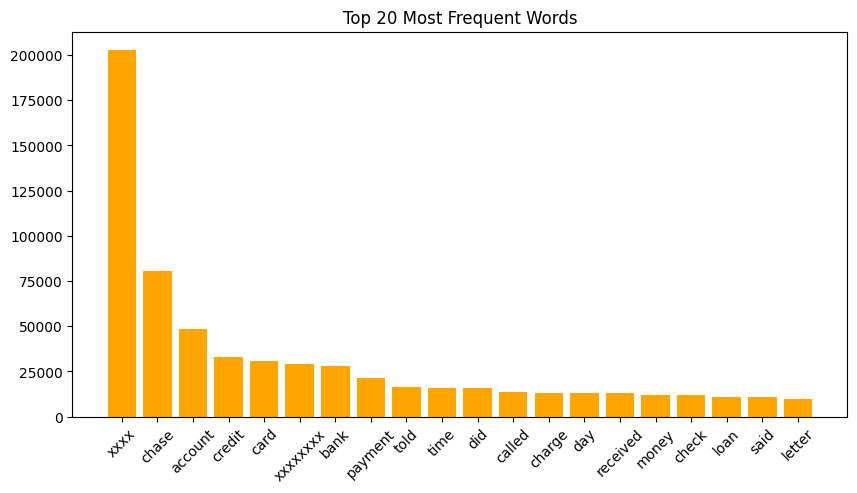

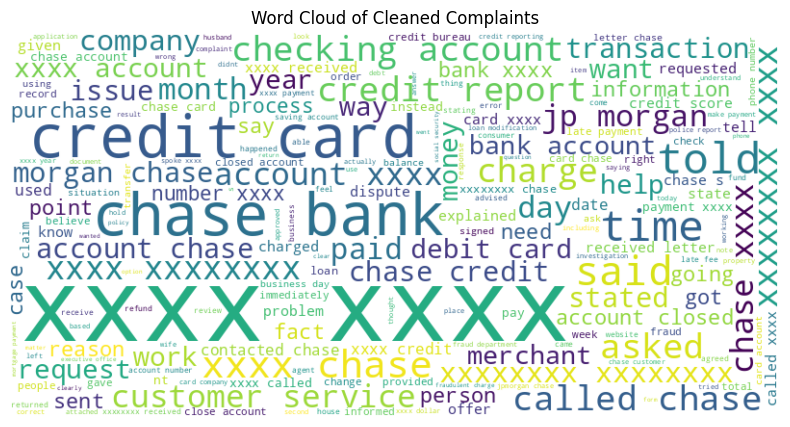

In [18]:
# 1. Complaint length (in words)
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Complaint Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 2. Top 20 most frequent words
all_words = ' '.join(df['clean_text']).split()
common_words = Counter(all_words).most_common(20)

# Plot common words
words, counts = zip(*common_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='orange')
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words')
plt.show()

# 3. Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Complaints')
plt.show()

# Step 4: Feature Extraction (TF-IDF)


*   TF (Term Frequency): How often a word appears in a document.
*   IDF (Inverse Document Frequency): How rare the word is across all documents.
*   TF-IDF gives higher weight to important words specific to a document.



In [19]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words='english')

# Fit and transform
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

# Output the shape
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")


TF-IDF matrix shape: (21072, 8490)


# Step 5: Topic Modeling using NMF
We'll extract 5 topics corresponding to the categories:
1.  Credit card / Prepaid card
2.  Bank account services
3.  Theft/Dispute reporting
4.  Mortgages/Loans
5.  Others

In [20]:
# Number of topics to extract
n_topics = 5

# Fit the NMF model
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_features = nmf_model.fit_transform(tfidf_matrix)

# Display top words per topic
def get_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        top_features = topic.argsort()[:-n_top_words - 1:-1]
        print(", ".join([feature_names[i] for i in top_features]))

# Show top words in each topic
feature_names = tfidf_vectorizer.get_feature_names_out()
get_top_words(nmf_model, feature_names, 10)



Topic #1:
xxxx, bank, chase, number, complaint, xxxxxxxxxxxx, sent, morgan, help, email

Topic #2:
account, check, bank, chase, money, fund, checking, closed, deposit, told

Topic #3:
credit, card, report, inquiry, chase, account, hard, score, reporting, balance

Topic #4:
payment, loan, mortgage, late, chase, xxxxxxxx, modification, month, home, paid

Topic #5:
xxxxxxxx, charge, chase, dispute, card, transaction, claim, merchant, fraud, received


Step 6: Model Building Using Supervised Learning

In [21]:
df['topic'] = np.argmax(nmf_features, axis=1)

# Preview topic distribution
print(df['topic'].value_counts())

# Optional: map topic numbers to category names (based on earlier keyword inspection)
topic_labels = {
    0: 'Credit card / Prepaid card',
    1: 'Bank account services',
    2: 'Theft/Dispute reporting',
    3: 'Mortgages/loans',
    4: 'Others'
}
df['topic_label'] = df['topic'].map(topic_labels)

# Preview data with assigned topic labels
df[['clean_text', 'topic', 'topic_label']].head()

topic
1    4838
0    4550
3    3961
2    3928
4    3795
Name: count, dtype: int64


,clean_text,topic,topic_label
1,good morning xxxx xxxx appreciate help stop ch...,0,Credit card / Prepaid card
2,upgraded xxxx xxxx card xxxx told agent did up...,0,Credit card / Prepaid card
10,chase card reported xxxx fraudulent applicatio...,2,Theft/Dispute reporting
11,xxxx trying book xxxx xxxx ticket came offer a...,2,Theft/Dispute reporting
14,grand son check deposit chase account fund cle...,1,Bank account services


Step 7: Model Training and Evaluation

Classification Report:

                            precision    recall  f1-score   support

     Bank account services       0.97      0.97      0.97       985
Credit card / Prepaid card       0.96      0.94      0.95       894
           Mortgages/loans       0.96      0.98      0.97       756
                    Others       0.96      0.95      0.95       757
   Theft/Dispute reporting       0.97      0.97      0.97       823

                  accuracy                           0.96      4215
                 macro avg       0.96      0.96      0.96      4215
              weighted avg       0.96      0.96      0.96      4215



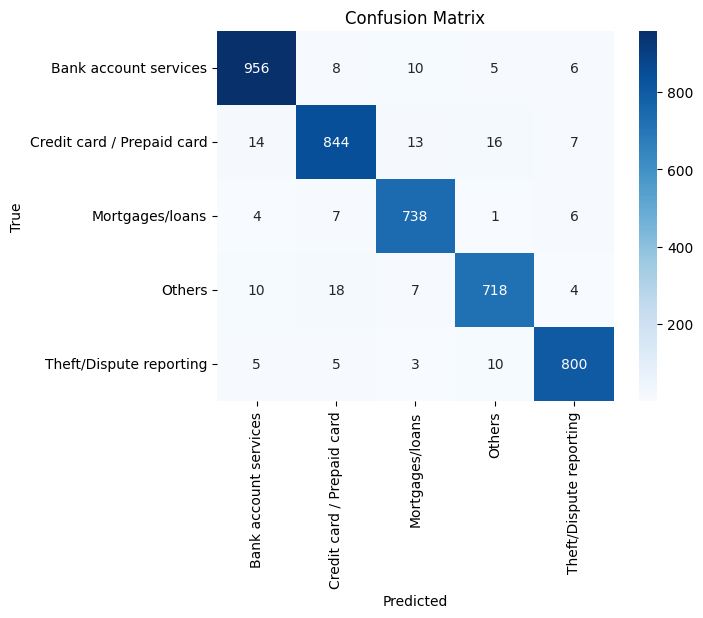

In [22]:
# Step 1: Prepare features and labels
X = tfidf_matrix
y = df['topic_label']  # or use df['topic'] if you prefer numerical labels

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the  using LogisticRegression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Predictions
y_pred = clf.predict(X_test)

# Step 5: Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Using Decision Tree


Classification Report (Decision Tree):

                            precision    recall  f1-score   support

     Bank account services       0.79      0.80      0.79       985
Credit card / Prepaid card       0.80      0.79      0.80       894
           Mortgages/loans       0.84      0.80      0.82       756
                    Others       0.67      0.69      0.68       757
   Theft/Dispute reporting       0.82      0.83      0.83       823

                  accuracy                           0.78      4215
                 macro avg       0.78      0.78      0.78      4215
              weighted avg       0.79      0.78      0.78      4215



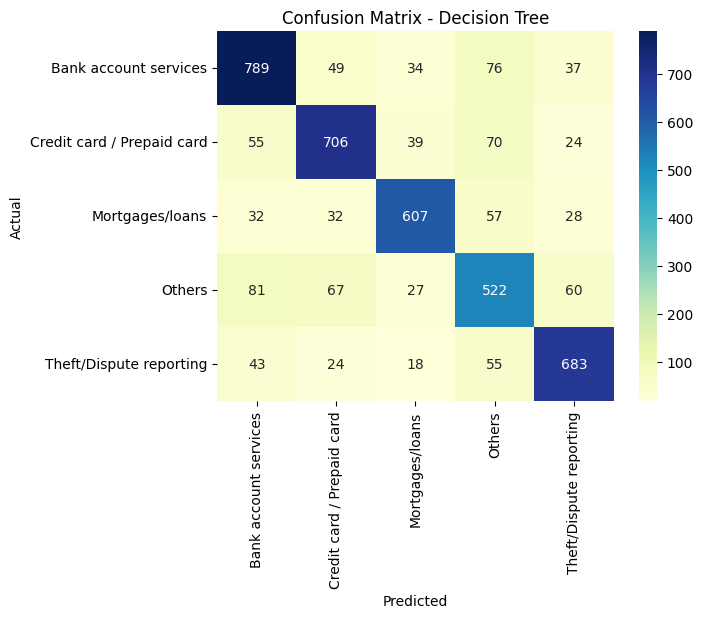

In [23]:
# Step 1: Prepare features and labels
X = tfidf_matrix
y = df['topic_label']  # Or use df['topic'] if you prefer numeric labels

# Step 2: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train the Decision Tree model
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=20)  # You can tune max_depth
dt_clf.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = dt_clf.predict(X_test)

# Step 5: Evaluate performance
print("Classification Report (Decision Tree):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=dt_clf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=dt_clf.classes_, yticklabels=dt_clf.classes_, cmap='YlGnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

Using Random Forest

Classification Report (Random Forest):

                            precision    recall  f1-score   support

     Bank account services       0.77      0.93      0.85       985
Credit card / Prepaid card       0.85      0.61      0.71       894
           Mortgages/loans       0.82      0.89      0.85       756
                    Others       0.83      0.70      0.76       757
   Theft/Dispute reporting       0.81      0.89      0.85       823

                  accuracy                           0.81      4215
                 macro avg       0.82      0.81      0.80      4215
              weighted avg       0.81      0.81      0.80      4215



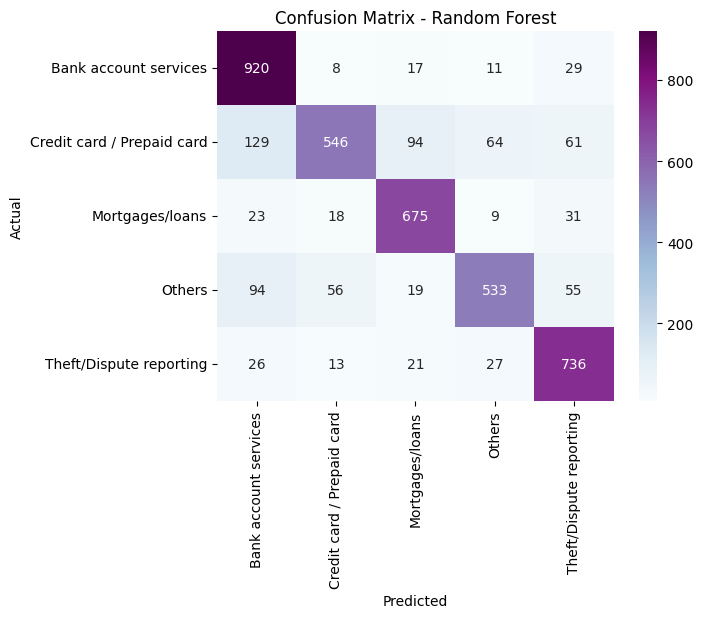

In [24]:
# Step 1: Prepare features and labels
X = tfidf_matrix
y = df['topic_label']  # or use df['topic'] for numeric labels

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize and train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
rf_clf.fit(X_train, y_train)

# Step 4: Predict
y_pred = rf_clf.predict(X_test)

# Step 5: Evaluate
print("Classification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=rf_clf.classes_)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_, cmap='BuPu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [25]:
#Comparing above 3 three models
# Features and labels
X = tfidf_matrix
y = df['topic_label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store models and their names
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=25, random_state=42)
}

# Dictionary to store performance
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')  # Macro for balanced class representation

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'F1 Score': round(f1, 4)
    })

# Create DataFrame with results
performance_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)

# Display the results
print("Model Performance Summary:\n")
print(performance_df.to_string(index=False))

Model Performance Summary:

              Model  Accuracy  F1 Score
Logistic Regression    0.9623    0.9621
      Random Forest    0.8090    0.8039
      Decision Tree    0.7846    0.7832


Step 8: Model Inference

In [26]:
# Change the model to rf_clf for random forest and clf to logistic regressor and dt_clf to Decision forest
def predict_complaint_from_test(index, model=rf_clf):
    # Ensure y_test is indexable from 0
    y_test_reset = y_test.reset_index(drop=True)

    # Get cleaned text from original df using y_test index
    cleaned_text = df.loc[y_test.index].reset_index(drop=True)['clean_text'][index]
    original_complaint = df.loc[y_test.index].reset_index(drop=True)['complaint_what_happened'][index]

    # Transform and predict
    tfidf_input = tfidf_vectorizer.transform([cleaned_text])
    predicted_label = model.predict(tfidf_input)[0]
    actual_label = y_test_reset[index]

    # Output
    print(f"Original Complaint:\n{original_complaint}\n")
    print(f"Cleaned Text:\n{cleaned_text}\n")
    print(f"Predicted Category: {predicted_label}")
    print(f"Actual Category   : {actual_label}")

In [27]:
# Testing results on model random_forest
predict_complaint_from_test(index=501, model=rf_clf)

Original Complaint:
I have a Satisfaction of Mortgage that Dates back to XX/XX/XXXX That Chase states it is not there Loan, and on XXXX I have a S.O.M From Chase which is in our Register of Deeds here in XXXX Wi. I found out that Chase Not there Loan, Is XXXX XXXX  XXXX The Doc. 
ID.Match. XXXX also states paid in Full as of XX/XX/XXXX I have a S.O.M. From XXXX. Dated XX/XX/XXXX. again recorded in our Register of Deeds here in XXXX Wi. 
Info Dates back to XXXX. XXXX XXXXXX/XX/XXXX Paid Account XXXX Balance XXXX XXXX XXXX.In XXXX was going to Foreclose our Home another S.O.M. I Found out it was a Home Equity Loan This went on for Months. Found out what it From in a Chase office in Louisiana. I have a letter From XXXX XXXX  where we stated in XXXX It went from XXXX XXXX to XXXX XXXX they went Belly Up. 
took over by XXXX. I do have a Letter from XXXX XXXX that my Servicer Is XXXX. Under Wi.Law If you received a S.O.M. endorsed with Time/Date/ and Document number from Register of Deeds Of

In [28]:
# Testing results on model Logistic regressor
predict_complaint_from_test(index=501, model=clf)

Original Complaint:
I have a Satisfaction of Mortgage that Dates back to XX/XX/XXXX That Chase states it is not there Loan, and on XXXX I have a S.O.M From Chase which is in our Register of Deeds here in XXXX Wi. I found out that Chase Not there Loan, Is XXXX XXXX  XXXX The Doc. 
ID.Match. XXXX also states paid in Full as of XX/XX/XXXX I have a S.O.M. From XXXX. Dated XX/XX/XXXX. again recorded in our Register of Deeds here in XXXX Wi. 
Info Dates back to XXXX. XXXX XXXXXX/XX/XXXX Paid Account XXXX Balance XXXX XXXX XXXX.In XXXX was going to Foreclose our Home another S.O.M. I Found out it was a Home Equity Loan This went on for Months. Found out what it From in a Chase office in Louisiana. I have a letter From XXXX XXXX  where we stated in XXXX It went from XXXX XXXX to XXXX XXXX they went Belly Up. 
took over by XXXX. I do have a Letter from XXXX XXXX that my Servicer Is XXXX. Under Wi.Law If you received a S.O.M. endorsed with Time/Date/ and Document number from Register of Deeds Of

In [29]:
# Testing results on model Logistic regressor
predict_complaint_from_test(index=501, model=dt_clf)

Original Complaint:
I have a Satisfaction of Mortgage that Dates back to XX/XX/XXXX That Chase states it is not there Loan, and on XXXX I have a S.O.M From Chase which is in our Register of Deeds here in XXXX Wi. I found out that Chase Not there Loan, Is XXXX XXXX  XXXX The Doc. 
ID.Match. XXXX also states paid in Full as of XX/XX/XXXX I have a S.O.M. From XXXX. Dated XX/XX/XXXX. again recorded in our Register of Deeds here in XXXX Wi. 
Info Dates back to XXXX. XXXX XXXXXX/XX/XXXX Paid Account XXXX Balance XXXX XXXX XXXX.In XXXX was going to Foreclose our Home another S.O.M. I Found out it was a Home Equity Loan This went on for Months. Found out what it From in a Chase office in Louisiana. I have a letter From XXXX XXXX  where we stated in XXXX It went from XXXX XXXX to XXXX XXXX they went Belly Up. 
took over by XXXX. I do have a Letter from XXXX XXXX that my Servicer Is XXXX. Under Wi.Law If you received a S.O.M. endorsed with Time/Date/ and Document number from Register of Deeds Of